In [2]:
%reload_ext autoreload

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar as cbr
import numpy as np
import numpy.ma as ma

from scipy.optimize import curve_fit
import pickle
from scipy.interpolate import interp1d
from lmfit import minimize, Parameters, report_fit, Minimizer
import corner
import lmfit
import sys
from pathlib import Path
home = str(Path.home())

sys.path.append(home +'\\OneDrive - Imperial College London\\dev\\')

from MagPy.Imaging import Image
from MagPy.Spectrometry import *
from MagPy.Thomson import S_k_omega
from MagPy.Ionisation import IaeaTable

# Load interferometry data as MagPy Image objects

In [6]:
%cd "~\OneDrive - Imperial College London\dev\MagPy\examples\TS example\"

s0215_22_neL = np.genfromtxt('./s0215_22 side on 532nm sh.csv', delimiter=',')
s0215_22_map    =   Image(s0215_22_neL, 68., 174)
s0215_22_map.set_origin([2470,1550])

C:\Users\0xDuckie\OneDrive - Imperial College London\dev\MagPy\examples\TS example


# Interpolation accross measured pin positions to get density for pos of each fiber

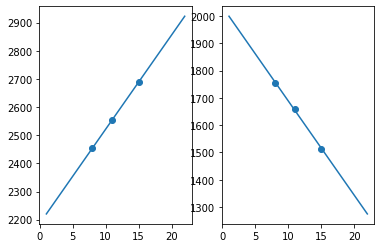

In [7]:
fib, x_px, y_px =   np.genfromtxt('./positions.csv', delimiter=',', skip_header=1, unpack=True)

f   = fib

xf = np.polyfit(f, x_px, deg = 1)
yf = np.polyfit(f, y_px, deg = 1)

ff = np.arange(1, 23, 1)
xs = np.polyval(xf, ff)
ys = np.polyval(yf, ff)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.scatter(f,x_px)
ax1.plot(ff, xs)

ax2.scatter(f, y_px)
ax2.plot(ff, ys)

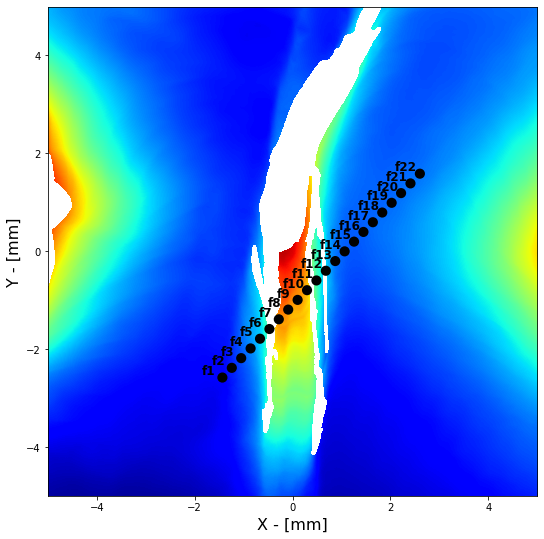

In [10]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredAuxTransformBox, AnchoredDirectionArrows
import matplotlib.font_manager as fm

fig, ax = plt.subplots(figsize=(9,9))
m = s0215_22_map.plot_mm(ax=ax, multiply_by = 1e-19, mask = 0.01, cmap = "jet", vmin = 0, vmax = 1)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel(r'X - [mm]', fontsize = 16)
ax.set_ylabel(r'Y - [mm]', fontsize = 16)
ax.grid(False)

x_mm = []
y_mm = []

for f, xm, ym in zip(ff, xs, ys):
    cord =  s0215_22_map.px_to_mm((xm, ym))
    c    =  plt.Circle((cord[0], cord[1]), 0.08,  ec='k', fc = 'k', lw = 2.3)
    ax.text(x=cord[0]-0.28, y=cord[1], va='bottom',ha='center',s = 'f' + str(f), color = 'k', weight = 'bold', fontsize=12)
    ax.add_artist(c)
    x_mm.append(cord[0])
    y_mm.append(cord[1])

## Interpolate Density profile along the TS Volume

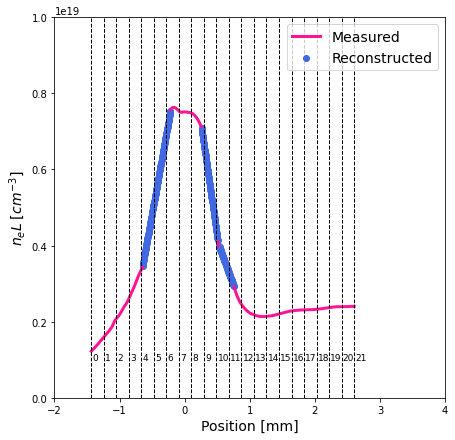

In [12]:
c1 = 'royalblue'
c2 = 'deeppink'

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

src = [x_mm[-1], y_mm[-1]]
dst = [x_mm[0], y_mm[0]]
r, nel = s0215_22_map.profile_mm(src, dst, 0.3)
x_line, y_line = r.transpose()

fig, ax = plt.subplots(figsize = (7,7))
ax.plot(x_line, nel, c = c2, lw = 3, label = 'Measured')

# filling the nans
nans, xnans = nan_helper(nel)
nel_inter = nel.copy()
nel_inter[nans]= np.interp(xnans(nans), xnans(~nans), nel_inter[~nans])

ax.scatter(x_line[nans], nel_inter[nans], c = c1, marker = 'o', label = 'Reconstructed')

for fib in range(0,22):
    pos = x_mm[fib]
    ax.axvline(pos, 0, 1, c='k', lw=1, ls='--')
    ax.annotate(str(int(fib)), (pos + 0.02, 1e18), size = 9)
 
ax.legend(fontsize = 14)
ax.set_ylabel(r'$n_e L\; [cm^{-3}]$', fontsize = 14)
ax.set_xlabel('Position [mm]', fontsize = 14)
ax.set_xlim(-2, 4)
ax.set_ylim(0, 1e19)

#  create function density profile
neL_as_function_of_x = interp1d(x_line, nel_inter)

def density(fiber_number):
    pos = x_mm[fiber_number]
    return neL_as_function_of_x(pos)

# np.savetxt(file_name + '-nel-thomson.csv', np.array([x_line, nel]).transpose())

# Now let's get our spectra out!

In [13]:
shot_spectrometer = Spectrometer('s0215_22 shot.asc')
background_spectrometer = Spectrometer(r'./s0215_22 bundle A in beam.asc')
bundle = Bundle(num_fibers=44)

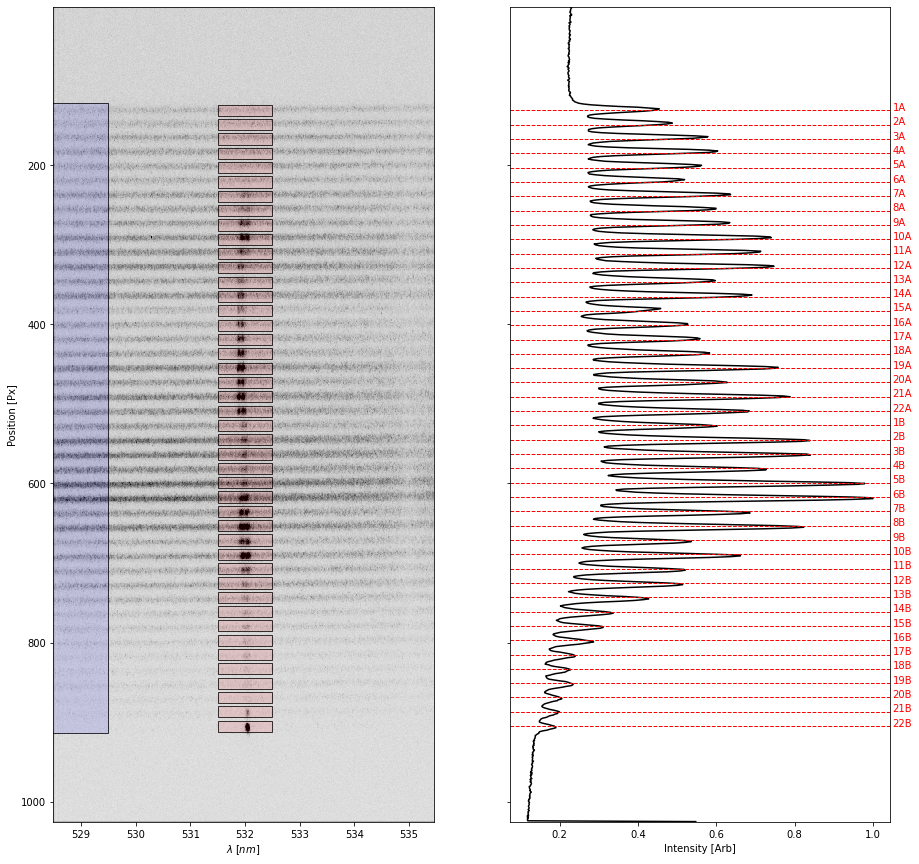

In [14]:
bundle.sp  = 18    # The spacing between fiber centres (in pixels)
bundle.off = 122    # The position of the centre of the uppermost fiber (in pixels)
bundle.dis = 2      # The number of pixels to ignore between each fiebr
bundle.l0  = 531.5     # The wavelength (in nm) of the LH side of the red boxes 
bundle.l1  = 532.5     # The wavelength (in nm) of the RH side of the red boxes
bundle.dl  = 528.  # The wavelength (in nm) of the LH side of the blue box (used to calculate dark count)
bundle.dw  = 1.5    # The width (in nm) of the blue box (used to calculate dark count)

bundle.draw_split(shot_spectrometer, vmin=200, vmax=1000) # Draw split to check we're all good...

In [15]:
bundle.split(shot_spectrometer, background_spectrometer) # Do the split & populate bundle.fibers

In [16]:
# pickle.dump(bundle, open('s0215_22_spectra.p', 'wb')) # save split

# Specify the ionisation model
The code in the next cell assumes a function named $z\_model(T_e[eV], n_e[cm^{-3}])$. Here we call a class to create this function by linearly interpolating over tabulated data which was generated using the atomic code FLYCHK.

Set the Variable atomic number to 14 as we're working with silicon

In [17]:
atomic_number = 14
atomic_mass = 28.
z_model = IaeaTable(atomic_number).model

# Define a Thomson Scattering model

In [18]:
def ThomsonModel(params, spectrum, atomic_mass, theta):
    # Set things up:
    T = params['T']   # Temp Te = Ti [eV]
    ne = params['ne']   # Electron density [cm^-3]
    Z = z_model(T, ne)
    vi = params['vi']   # Ion speed [m/s]
    vd = params['vd']   # Electron drift speed [m/s]
    stray_amp = params['stray_amp'] # Intensity of stray light [Arb]
    amp = params['amp'] # Intensity of Thomson signal [Arb]
    se_amp = params['self_emission'] # Intensity of constant offset from self emission [Arb]
    
    l = spectrum.l      # Spectral subgird (upon which scattering model calculated) [nm]
    l0 = spectrum.get_probe_wavelength() # Probe wavelength [nm]
    y_data = spectrum.s_y     # Shot Intensity data from the spectrum object
    y_error = spectrum.s_yerr # Shot Intensity error from the spectrum object
    y_se = spectrum.y_se 
    y_stray = spectrum.y_stray
    
    # Where the physics lives:
    S, alpha = S_k_omega(l, l0, theta, atomic_mass, T, T, ne, Z, vi, vd) # Calculate spectral density on subgrid scale
    model = spectrum.convolve_fixed_grid(S) # Calculate convolution with response, return values on subgrid
    model *= amp/model.max() # Scale spectrum by fit-amplitude
    model += stray_amp*y_stray # Add contribution from srtay light
    model += se_amp*y_se # Add contribuiton from self-emission
    return model, alpha


# Define a function to calculate the residual, and one to plot fitted data
Note in the calculation of the residual, we don't include "error" from varience in spatial direction. 

In [19]:
def Residual(params, spectrum, model, **kwargs):
    m = model(params, spectrum, **kwargs)[0]
    m = spectrum.downsample_to_data_grid(m) 
    y_data = spectrum.s_y
    y_error = spectrum.s_yerr
    residual = (y_data-m)**2
    return residual

def Plot(ax, minimizer_result, spectrum, model, **kwargs):
    params = minimizer_result.params
    l0 = spectrum.get_probe_wavelength()
    dl = 0.35
    x1 = dl
    x0 = -dl
    ax.set_xlim(x0, x1)
    
    x_data = spectrum.s_l
    y_data = spectrum.s_y
    y_error = spectrum.s_yerr
    x_fit = spectrum.l
    y_fit, alpha = model(params, spectrum, **kwargs)
    print(alpha)
    
    y0 = 0
    y1 = (y_data+y_error).max()*1.01
    ax.set_ylim(y0,y1)
    
    r_sc = 0.8*y_data.max()
    x_response = spectrum.l
    y_response = r_sc*spectrum.get_response(x_response)
    x_laser = spectrum.b_l
    y_laser = spectrum.b_y
    y_laser *= r_sc / y_laser.max()
    
    ax.step(x_response-l0, y_response, label='Response', c='k', lw=2.5, zorder=1, alpha = 1)
    ax.fill_between(x_laser-l0, y_laser - y_error, y_laser + y_error, step='mid', color='k', alpha=0.5)
    ax.plot(x_fit-l0, y_fit, zorder=1, c='red', lw = 3, alpha = 0.8, label='Best Fit')
    ax.fill_between(x_data-l0, y_data - y_error, y_data + y_error,step='mid', color='red', alpha=0.5)
    
    ax.set_xlabel('$\Delta \lambda \; [nm]$')
    ax.set_ylabel('Intensity [Arb]')
    
    ax.annotate('$T$ = %.1f eV\n$V_i$ = %.2f$\\times \
    10^4$ m/s\n$V_d$ = %.2f$\\times 10^4$ m/s\n$\\alpha$ = %.2f\n $\\chi^2_\\nu$ = %.0f' \
    %(params['T'].value, params['vi'].value/1e4, \
      params['vd'].value/1e4, alpha[0], minimizer_result.redchi),xy=(0.65,.5), \
    xycoords='axes fraction',ha="left", va="top", \
    bbox=dict(boxstyle="round", fc='1'),fontsize=10)
    ax.legend()

# Select the spectrum from a particular fiber and prepare spectrum for fitting
1. Select the spectrum from the bundle by changing the key to match a fiber label from the plot above
2. Fit Voigt response to the background spectrum, and save fitting parameters internally to the spectrum object
3. Setup a fixed spectral grid onto which the the theoretical scattering spectrum should be calculated, along with a Voigt kernal (on the same grid) to be used for convolution. This grid may have to be finer than the data-grid, if the width of features in the spectrum are comparable to the separation of points in the data. The setup function takes 2 arguments:
    - **w_grid**: spacing between grid points as a fraction of the FWHM of the fitted instrument response. Value should be <= 1. Smaller values are more accurate but convolutions will be slower.
    - **w_kernal**: width of the kernel as a multiple the width of the computed kernel for convolution, as a  multiple of the FWHM of the instrument response. Value should be >= 1. Larger values will be more accurate but slower. 

In [22]:
fiber_number = 18
Ne = density(fiber_number)/0.5
print(Ne)
key = str(fiber_number) + 'A'
fiber = bundle.fibers[key] # Select spectrum for a fiber
fiber.fit_response()        # Fit response to background data
fiber.setup_convolution_grid(w_grid=0.01, w_kernal=5.) # Setup fixed grid & a kernal for efficient convolution

4.643604853875682e+18


[5.49175437 5.49175604 5.4917577  ... 5.4968813  5.49688296 5.49688462]


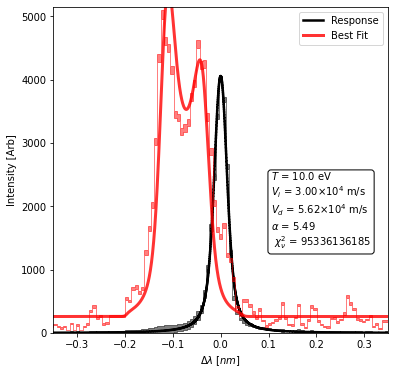

In [23]:
key_word_args = { 
    'model': ThomsonModel,
    'spectrum': fiber,
    'atomic_mass': atomic_mass,  
    'theta': 90,                 # Theta [degrees] specified here.
}
params = Parameters()
params.add('T', value=10, min=1, max=30, vary=False)
params.add('ne', value=Ne, vary=False)
params.add('vi', value=3e4, vary=False)
params.add('vd', value=1e1, vary=True)
params.add('amp', value=1300, min=100, max=6000, vary=True)
params.add('stray_amp', value=100., min=0., max=1, vary=False)
params.add('self_emission', value=260, min=0., max=500, vary=False)

#out = minimize(Residual, params, kws=key_word_args, calc_covar=True)
mini = Minimizer(Residual, params, fcn_kws=key_word_args, calc_covar=True)
out = mini.minimize()

fig, ax = plt.subplots(figsize = (6,6))
Plot(ax, out, **key_word_args)
out

### Save fit

In [39]:
# f = './fits/' + str(fiber_number) + 'A.p'
# pickle.dump(out, open(f, 'wb'))

# Plot profiles of measured params for one specific bundle
### Example of for-loop to plot the plasma parameters from the fitted spectra

In [76]:
T = []
dT = []
Vi = []
dVi = []
X = []
dX = []
Ne = []
results = []


for fiber_number in range(9,11):
    key = str(fiber_number) + 'B'
    key_word_args = { 
        'model': ThomsonModel,
        'spectrum': fiber_number,
        'z_model': z_model,             # If you change atomic_number here then
        'atomic_number': atomic_number, # dont forget to update z_model also!! 
        'theta': 90.,                 # Theta [degrees] specified here.
    }
    res = pickle.load(open("./fits/" + key + ".p", "rb"))
    t = res.params['T'].value
    T.append(t)
    dt = max(0.1, res.params['T'].stderr)
    dT.append(dt)
    vi = res.params['vi'].value
    Vi.append(vi)
    dvi = res.params['vi'].stderr
    dVi.append(dvi)
    x = fib_position_x(fiber_number)
    X.append(x)
    dx = 0.125
    dX.append(dx)
    ne = res.params['ne'].value
    Ne.append(ne)
    results.append(res)

T = np.array(T)
dT = np.array(dT)
Vi = np.array(Vi)
dVi = np.array(dVi)
X = np.array(X)
dX = np.array(dX)